#BLah blah balh
--------------------
The intensity of an $H_2$ line $I = {A \Delta E~N_u \over 4\pi}$, so from a measured intensity $I$ we can calculate the column density inthe upper state $N_u = 4\pi {I\over A\Delta E}$, where $A$ is the Einstein A coefficient and $\Delta E$ is the energy difference associated with the transition.

The excitation diagram plots $log(N_u/g_u)$ on the y-axis versus the upper state energy of the transition $E_J$ on the x-axis.   The statistical weight $g_u = OPR \times(2J+1)$, where $OPR$ is the ortho-to-para ratio and in LTE is equal to 1 for even $J$ and 3 for odd $J$.  If $OPR$ differs from (is less than) 3 for odd $J$, then the actual $N_u/g_u$ will increase over its LTE value, but on a traditional plot with LTE $g_u$, $N_u$ will be measured as too low.  This creates the so-called "zig-zag" pattern in the excitation diagram.

We can fit for $T_{cold}, T_{hot}$, $N_{total} = N_{cold}+ N_{hot}$, and optionally $OPR$.  One needs at least 5 points to fit the temperatures and column densities (slope and intercept $\times 2$), though one  could compute (not fit) them with only 4 points. To additionally fit $OPR$, one should have 6 points (5 degrees of freedom). 

In [1]:
from pdrtpy.measurement import Measurement
from pdrtpy.tool.h2excitation import H2ExcitationFit
from pdrtpy.plot.h2excitationplot import ExcitationPlot
import pdrtpy.pdrutils as utils
from pdrtpy.modelset import ModelSet
from pdrtpy.plot.modelplot import ModelPlot
from astropy.nddata import StdDevUncertainty
import astropy.units as u
import numpy as np
import matplotlib.pyplot as plt

/home/mpound/anaconda3/lib/python3.7/site-packages/astropy/table/column.py:1161: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = getattr(super(), op)(other)


## This example shows $H_2$ excitation diagram fitting.
## The excitation diagram is Energy levels vs upper state column density. 
From intensity measurements of $H_2$ rovibrational transitions, one can calculate the normalized upper state column density $N_u/g_u$ for each transition (assuming LTE).  Using an excitation diagram, which is plot of upper state energy $E_u/k$ vs. $log(N_u/g_u)$, one can then determine the gas temperature and total gas column density.  Often, excitation diagrams show evidence of both "hot" and "cold" gas components, where the cold gas dominates the intensity in the low $J$ transitions and the hot gas dominates in the high $J$ transitions. Given enough intensities (at least 4) one can fit the excitation diagram for $T_{cold}, T_{hot}, N_{cold}, N_{hot}$. The total $H_2$ column density is $N_{total} = N_{cold} + N_{hot}$.

## We start with some test data, which are intensities of several $H_2$ lines
#### We put these into `Measurement`s which we will pass along to the fitting tool. 

In [2]:
intensity = dict()
intensity['H200S0'] = 3.00e-05
intensity['H200S1'] = 5.16e-04
intensity['H200S2'] = 3.71e-04
intensity['H200S3'] = 1.76e-03
intensity['H200S4'] = 5.28e-04
intensity['H200S5'] = 9.73e-04
a = []
for i in intensity:
    m = Measurement(data=intensity[i],uncertainty=StdDevUncertainty(intensity[i]),
                    identifier=i,unit="erg cm-2 s-1 sr-1")
    a.append(m)

## Instantiate the excitation diagram fitting tool
**NOTE: The intensities are assumed to be extinction-corrected**.

In [3]:
h = H2ExcitationFit(a)

### The energy levels for the input `Measurements` are calculated by the fitting tool, $E_u/k$ in units of K
They are returned as a dictionary with the line identifiers as the keys (line=True) or with the J levels as the keys (line=False).

In [4]:
print(h.energies(line=True))

{'H200S0': 509.8, 'H200S1': 1015.0, 'H200S2': 1682.0, 'H200S3': 2504.0, 'H200S4': 3474.0, 'H200S5': 4586.0}


In [5]:
foo=h.average_column_density(line=False)
foo[2].error

3.643599805183062e+19

## Fit a two-temperature model 
 The fit is done using the [lmfit package](https://github.com/lmfit/lmfit-py) and the return value `fit_param` is an [lmfit.model.ModelResult.](https://lmfit.github.io/lmfit-py/model.html#the-modelresult-class) ModelResult has methods by which you can [print the details of the fit](https://lmfit.github.io/lmfit-py/model.html#lmfit.model.ModelResult.fit_report) and [plot the data, residuals, and fit](https://lmfit.github.io/lmfit-py/model.html#lmfit.model.ModelResult.plot).  These are useful for a quick check of your results.   Fancier plotting with PDRT is described below. 

First guess at excitation temperatures:
 T_cold = 268.8 K
 T_hot = 703.2 K
Fitted excitation temperatures and column densities:
 T_cold = 210+/-5.1 K
 T_hot = 693+/-5.8 K
 N_cold = 1.81e+21+/-1.3e+20 1 / cm2
 N_hot = 2.05e+20+/-8.7e+18 1 / cm2
 N_total = 2.01e+21+/-1.3e+20 1 / cm2

FIT REPORT:
 [[Model]]
    Model(_modelfunc)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 26
    # data points      = 6
    # variables        = 4
    chi-square         = 0.00463796
    reduced chi-square = 0.00231898
    Akaike info crit   = -34.9914436
    Bayesian info crit = -35.8244057
[[Variables]]
    m1:  -0.00206683 +/- 5.0229e-05 (2.43%) (init = -0.001615661)
    n1:   20.5414585 +/- 0.03031415 (0.15%) (init = 20.38519)
    m2:  -6.2675e-04 +/- 5.2510e-06 (0.84%) (init = -0.0006176355)
    n2:   19.0778188 +/- 0.01837808 (0.10%) (init = 19.03854)
    opr:  3 (fixed)
[[Correlations]] (unreported correlations are < 0.100)
    C(m2, n2) = -0.962
    C(m1, n1) = -0.939


(<Figure size 432x432 with 2 Axes>, GridSpec(2, 1, height_ratios=[1, 4]))

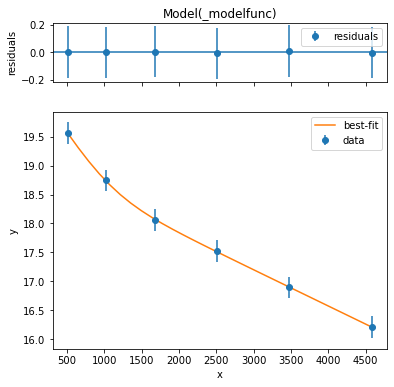

In [6]:
fit_param = h.run()
print("\nFIT REPORT:\n",fit_param.fit_report())
fit_param.plot(numpoints=30)

In [7]:
h.total_colden

/home/mpound/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


2.0104344902786272e+21 +/- 1.2633399692596055e+20 1 / cm2

## Plot the results
Each tool in the PDR Toolbox has an associated plotter which is instantiated by passing it a reference to the tool.   The tool here is `ExcitationPlot`.  The arguments are a reference to the `H2ExcitationFit` tool and a label for the data (LaTeX okay here, \$ signs will be added).  The `plot_diagram()` method can show the data normalized or unnormalized and can show the results of the fit with `show_Fit=True`.  As with other PDRT plots, the axis limits are controlled with `xmin, xmax, ymin, ymax.`

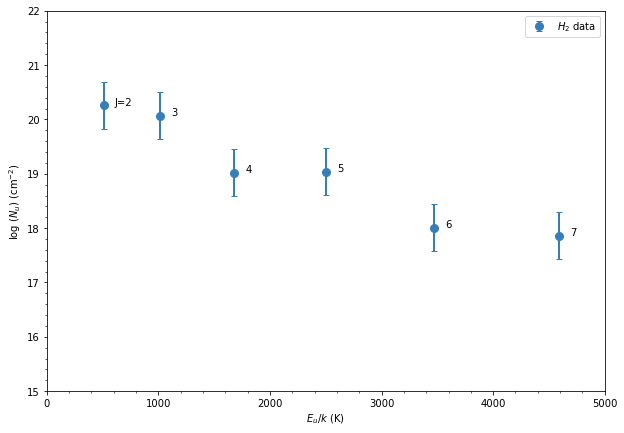

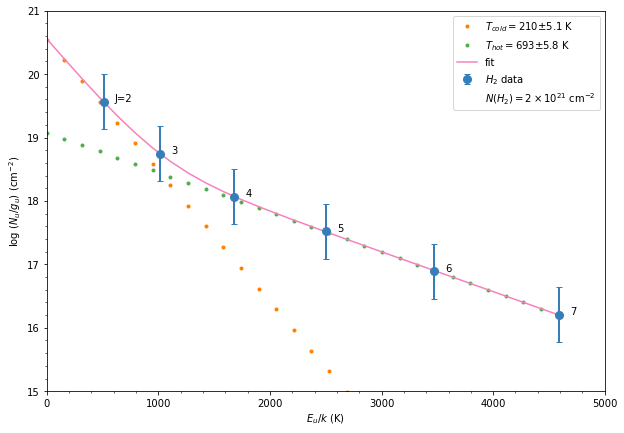

In [8]:
hplot = ExcitationPlot(h,"H_2")
hplot.plot_diagram(norm=False)
hplot.plot_diagram(show_fit=True,ymax=21)

## 2.  What if we want to fit the ortho-to-para ratio as well?
Let's start with some example data based on [Sheffer et al 2011](https://iopscience.iop.org/article/10.1088/0004-637X/741/1/45/pdf), Figure 9:
![Sheffer](ShefferEtAlFig9_sm.png)

They found $OPR = 1.88, T_{hot} = 685~{\rm K},  T_{cold}=206~{\rm K}$.   We'll create some data by reading it off the graph (tip o' the hat to [graphreader.com](http://graphreader.com))

In [9]:
intensity = dict()
intensity['H200S0'] = 3.003e-05
intensity['H200S1'] = 3.143e-04
intensity['H200S2'] = 3.706e-04
intensity['H200S3'] = 1.060e-03
# Add a point for J=6 so that the fit is not overconstrained.
intensity['H200S4'] = 5.282e-04
intensity['H200S5'] = 5.795e-04
a = []
for i in intensity:
    m = Measurement(data=intensity[i],uncertainty=StdDevUncertainty(0.75*intensity[i]),
                    identifier=i,unit="erg cm-2 s-1 sr-1")
    a.append(m)

/home/mpound/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Now set `fit_opr=True` in `run()`.   

In [10]:
hopr = H2ExcitationFit(a)
fit_param=hopr.run(fit_opr=True)
fit_param

First guess at excitation temperatures:
 T_cold = 212.6 K
 T_hot = 529.5 K
Fitted excitation temperatures and column densities:
 T_cold = 207+/-1.4 K
 T_hot = 688+/-1.5 K
 N_cold = 1.84e+21+/-3.4e+19 1 / cm2
 N_hot = 2.07e+20+/-2.1e+18 1 / cm2
 N_total = 2.05e+21+/-3.4e+19 1 / cm2


/home/mpound/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


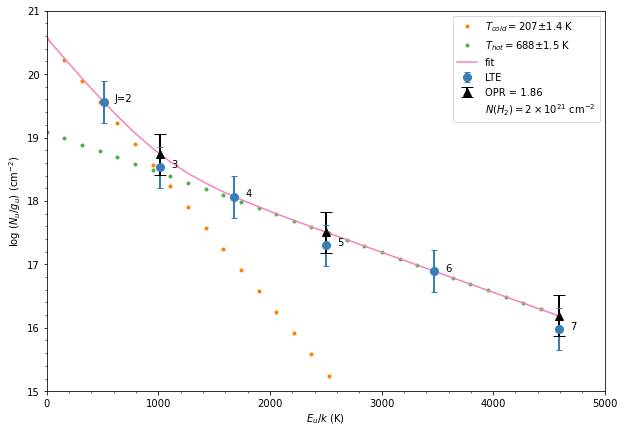

In [11]:
hploto = ExcitationPlot(hopr,"H_2")
hploto.plot_diagram(show_fit=True,ymax=21)

### The individual parameters are accessible in the ExcitationFit
Most are returned as `Measurement` which can be used with Python f-strings.

In [12]:
print(hopr.thot)
print(hopr.tcold)
print('N_cold = ',hopr.hot_colden)
print(hopr.cold_colden)
print(f'{hopr.total_colden:+.1e}')
print(f"{hopr.opr:.2f}")
"{:>8.3f}".format(hopr.thot)

687.6067645742422 +/- 1.4749371890019451 K
206.95989223703847 +/- 1.4006228447827371 K
N_cold =  2.069576448618457e+20 +/- 2.0644829066951516e+18 1 / cm2
1.8418055863464792e+21 +/- 3.4200770883484983e+19 1 / cm2
+2.0e+21 +/- +3.4e+19 1 / cm2
1.86 +/- 0.01 


/home/mpound/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


' 687.607 +/-    1.475 K'

## now do a map
#### Read in some test $H_2$ intensity images from FITS files.  
The maps are 2D Gaussian blobs with peak intensities as in the OPR-fitting example above, and with Gaussian noise of 25% of the peak value added. 

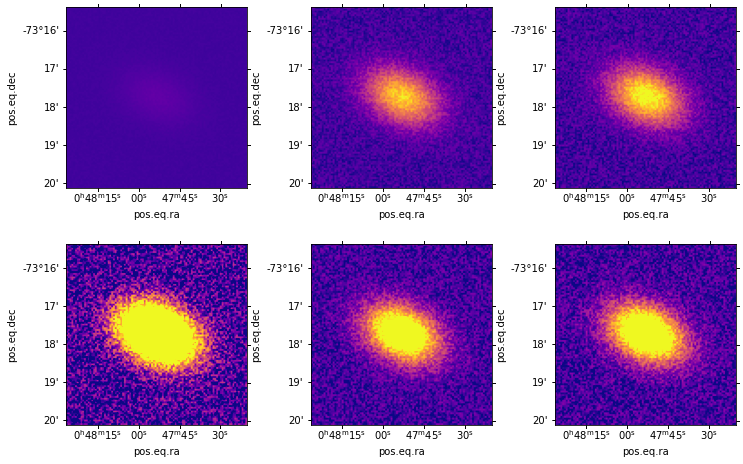

In [13]:
q = []
for j in intensity:
    infile=f"../data/{j:s}_test_data.fits"
    m = Measurement.read(infile,identifier=j)
    q.append(m)
# pick a single scale for all the plots
vmin=q[1].data.min()
vmax=q[1].data.max()
    
fig,ax = plt.subplots(2,3,subplot_kw={'projection':q[0].wcs},figsize=(12,8))
i = 0
for a in ax:
    for b in a:
        b.imshow(q[i],origin="lower",vmin=vmin,vmax=vmax,cmap='plasma')
        i = i+1
plt.subplots_adjust(wspace=.35)


### First, Choose a spatial area in the image data to average the column densities over.
#### The area center `position` and `size` can be pixels or astronomical coordinates.  `astropy's Cutout2D` is underneath the hood.

In [14]:
hmap = H2ExcitationFit(q)

/home/mpound/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [15]:
x = 45
y = 45
size=(12,12)
cd=hmap.average_column_density(norm=True,position=(x,y),size=size,line=True)
for k in cd:
    print(k,"{:5.3e}".format(cd[k]))
tc=hmap.column_densities(line=True)
#h3 = H2ExcitationFit(list(cd.values()))
print(np.shape(tc['H200S1'].error))
print(tc['H200S1'].error.size)
tc['H200S1'].error.mean()/tc['H200S1'].data.max()

H200S0 2.586e+19 +/- 9.118e+16 1 / cm2
H200S1 2.432e+18 +/- 8.471e+15 1 / cm2
H200S2 8.299e+17 +/- 2.897e+15 1 / cm2
H200S3 1.431e+17 +/- 4.988e+14 1 / cm2
H200S4 5.643e+16 +/- 1.954e+14 1 / cm2
H200S5 6.895e+15 +/- 2.393e+13 1 / cm2
(100, 100)
10000


0.22236754613345097

/home/mpound/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


First guess at excitation temperatures:
 T_cold = 213.7 K
 T_hot = 528.9 K
Fitted excitation temperatures and column densities:
 T_cold = 209+/-2.6 K
 T_hot = 689+/-2.8 K
 N_cold = 1.29e+21+/-4.4e+19 1 / cm2
 N_hot = 1.48e+20+/-2.7e+18 1 / cm2
 N_total = 1.44e+21+/-4.4e+19 1 / cm2
[[Model]]
    Model(_modelfunc)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 31
    # data points      = 6
    # variables        = 5
    chi-square         = 2931527.28
    reduced chi-square = 2931527.28
    Akaike info crit   = 88.5956478
    Bayesian info crit = 87.5544451
[[Variables]]
    m1:  -0.00208092 +/- 2.6124e-05 (1.26%) (init = -0.002032274)
    n1:   20.3982669 +/- 0.01494169 (0.07%) (init = 20.44875)
    m2:  -6.3004e-04 +/- 2.5147e-06 (0.40%) (init = -0.0008210654)
    n2:   18.9377281 +/- 0.00808242 (0.04%) (init = 19.60391)
    opr:  1.85745453 +/- 0.01673343 (0.90%) (init = 3)
[[Correlations]] (unreported correlations are < 0.100)
    C(m1, n1)  = -0.948
   

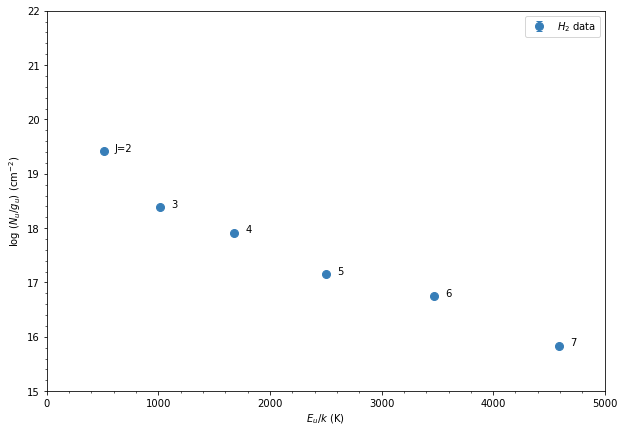

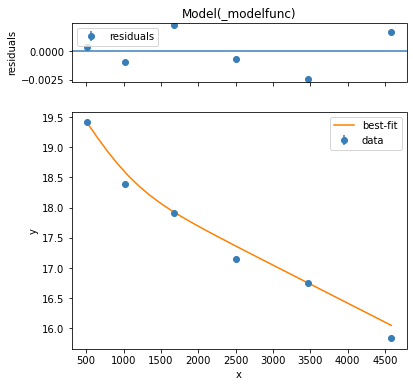

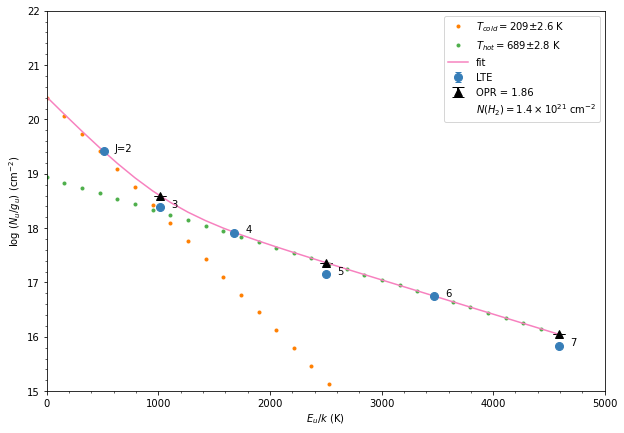

In [16]:
hp = ExcitationPlot(hmap,"H_2")
hp.plot_diagram(position=(x,y),size=size,norm=True)
f=hmap.run(position=(x,y),size=size,fit_opr=True)
print(f.fit_report())
f.plot(numpoints=30)
hp.plot_diagram(position=(x,y),size=size,norm=True,show_fit=True)